In [13]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
TIMELINE_F = '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Extracted_Per_Event_Interictal/all_time_data_01042023_212306.csv'
SEEG_FOLDER = '/mnt/ernie_main/000_Data/SEEG/SEEG_Entire_EMU_Downloads/data/'

In [3]:
seeg_timeline_df = pd.read_csv(TIMELINE_F, delimiter="\t")
seeg_timeline_df.head(5)

,Type,Pat ID,Event Number (Matches EMU Final Report),Date (MM:DD:YYYY),Onset String (HH:MM:SS),Offset String (HH:MM:SS),Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown),FileIndex,onset_datetime,offset_datetime,onset_datetime_buffer,offset_datetime_buffer,FileName
0,File,Epat02,File1,09:14:2017,13:05:11,17:05:11,NaN,0,2017-09-14 13:05:11,2017-09-14 17:05:11,2017-09-14 13:06:11,2017-09-14 17:04:11,Epat02_09142017_13051100.EDF
1,File,Epat02,File2,09:14:2017,17:05:22,21:05:22,NaN,1,2017-09-14 17:05:22,2017-09-14 21:05:22,2017-09-14 17:06:22,2017-09-14 21:04:22,Epat02_09142017_17052200.EDF
2,File,Epat02,File3,09:14:2017,21:05:34,01:05:34,NaN,2,2017-09-14 21:05:34,2017-09-15 01:05:34,2017-09-14 21:06:34,2017-09-15 01:04:34,Epat02_09142017_21053400.EDF
3,File,Epat02,File4,09:15:2017,01:05:45,05:05:45,NaN,3,2017-09-15 01:05:45,2017-09-15 05:05:45,2017-09-15 01:06:45,2017-09-15 05:04:45,Epat02_09152017_01054500.EDF
4,File,Epat02,File5,09:15:2017,05:05:56,09:05:56,NaN,4,2017-09-15 05:05:56,2017-09-15 09:05:56,2017-09-15 05:06:56,2017-09-15 09:04:56,Epat02_09152017_05055600.EDF


In [15]:
label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Using Precomputed PDC Peri-Ictally

In [16]:
data_dir = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/'
folders = glob.glob(os.path.join(data_dir, "*pat*"))
sub_ids = [os.path.basename(f) for f in folders]

In [6]:
tst_folders = folders[0:2]
tst_subj = sub_ids[0:2]

In [53]:
tst_df = agg_subjects(folders[0:2], sub_ids[0:2], label_df)

In [55]:

peri_ictal_df = agg_subjects(folders, sub_ids, label_df)

/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98: RuntimeWarning: Mean of empty slice
  net_pz = np.nansum(pz_in) - np.nansum(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:98:

In [56]:
peri_ictal_df

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,0.016122,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,-0.002804,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,0.000132,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,0.018198,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,-0.002385,theta,Epat02_10_FIAS_imcoh.mat
...,...,...,...,...,...,...
67,Spat52,post,pz,-0.015996,gamma_l,Spat52_7_FIAS_imcoh.mat
68,Spat52,post,nz,0.002229,gamma_l,Spat52_7_FIAS_imcoh.mat
69,Spat52,post,soz,-0.016702,gamma_H,Spat52_7_FIAS_imcoh.mat
70,Spat52,post,pz,-0.016668,gamma_H,Spat52_7_FIAS_imcoh.mat


In [22]:
f = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_19_FAS_imcoh.mat'
tst_obj = load_mat(f)
tst_obj

wut


In [21]:
tst_obj

In [26]:
peri_ictal_df.to_csv("../data/peri_ictal_conn.csv",index=False)

## Analyzing Peri Ictal Dynamics

In [27]:
peri_ictal_df.head(5)

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,2.192529,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,-2.668998,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,0.476469,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,2.474896,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,-2.270837,theta,Epat02_10_FIAS_imcoh.mat


In [31]:
alpha_peri_df = peri_ictal_df[peri_ictal_df.freq_band == 'alpha']
alpha_peri_df = alpha_peri_df[['subj','period','region','net_pdc']]

In [ ]:
# 0 - NIZ 
# 1 - SOZ 
# 2 - PZ
# 3 - IZ

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

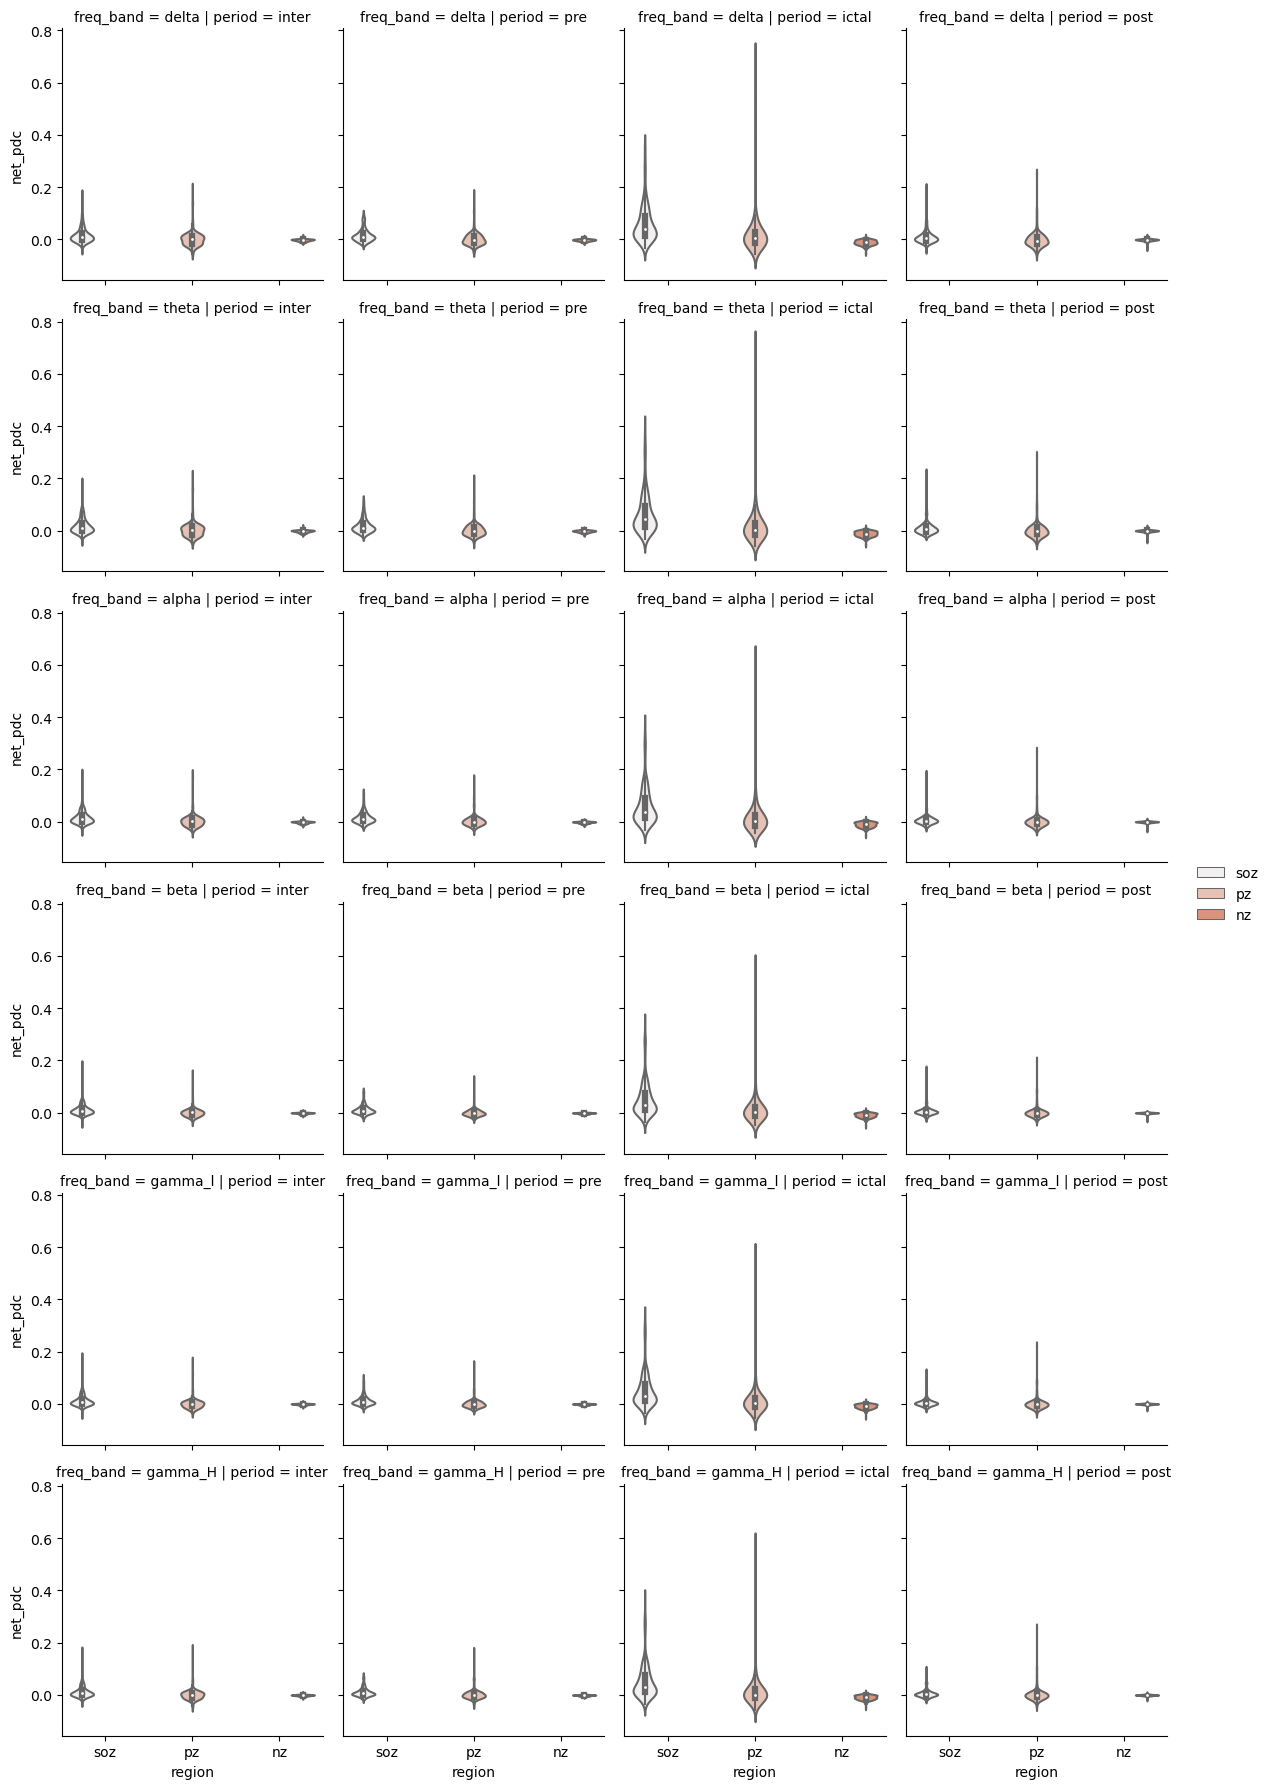

In [57]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.color_palette("flare"):
    grid = sns.FacetGrid(peri_ictal_df,col='period', row='freq_band',col_order=['inter','pre','ictal','post']) 
    grid.map_dataframe(sns.violinplot, y='net_pdc',x='region', positions=[1,2,3], hue='region')
    grid.add_legend()
    grid.tight_layout()
